In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import rc
import pandas as pd
#import seaborn as sns

#rc('text', usetex=True)
#rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
#rc('font',**{'family':'serif','serif':['cmr']})

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, UpSampling2D, Input, ZeroPadding2D, Lambda, Reshape
from tensorflow.keras.layers import BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
#import tensorflow_probability as tfp

from scipy import stats
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.losses import mse, binary_crossentropy,mean_absolute_error ,huber
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.constraints import unit_norm, max_norm
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#import nibabel as nib
import scipy as sp
import scipy.ndimage
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.manifold import MDS

2.7.1


In [30]:
import latex

# LOADING THE DATASET

In [3]:
hf=h5py.File("../../img_p+Fe_MST+SST_10000.hdf5", 'r')
hf.keys()

<KeysViewHDF5 ['MST', 'SST']>

In [4]:
def aux_features(file):
    
    aux_vars = pd.read_csv(file).drop(columns=['Unnamed: 0'])
    scaler = StandardScaler()
    aux_vars = scaler.fit_transform(aux_vars)
    
    return aux_vars

# SST (48X48) and MST(112X112) IMAGES

In [5]:
data_MST = hf['MST']
data_SST = hf['SST']
data_MST.keys()

<KeysViewHDF5 ['ENERGY', 'LABEL', 'XMAX', 'X_MONO', 'X_STEREO', 'Y']>

# MONO (1 TELESCOPE) and STEREO(>1 TELESCOPES)

In [6]:
imgs_MST_MONO = data_MST['X_MONO']
imgs_MST_STER = data_MST['X_STEREO']
imgs_SST_MONO = data_SST['X_MONO']
imgs_SST_STER = data_SST['X_STEREO']


# separated by species
imgs_MST_MONO_Fe = imgs_MST_MONO[0]
imgs_MST_MONO_p  = imgs_MST_MONO[1]
imgs_MST_STER_Fe = imgs_MST_STER[0]
imgs_MST_STER_p  = imgs_MST_STER[1]

imgs_SST_MONO_Fe = imgs_SST_MONO[0]
imgs_SST_MONO_p  = imgs_SST_MONO[1]
imgs_SST_STER_Fe = imgs_SST_STER[0]
imgs_SST_STER_p  = imgs_SST_STER[1]

#p+Fe images
imgs_MST_MONO_Fe_p = np.concatenate((imgs_MST_MONO_Fe, imgs_MST_MONO_p), axis=0)
imgs_MST_STER_Fe_p = np.concatenate((imgs_MST_STER_Fe, imgs_MST_STER_p), axis=0)

imgs_SST_MONO_Fe_p = np.concatenate((imgs_SST_MONO_Fe, imgs_SST_MONO_p), axis=0)
imgs_SST_STER_Fe_p = np.concatenate((imgs_SST_STER_Fe, imgs_SST_STER_p), axis=0)

In [7]:
def normalize_img(data):
    x_min = np.min(data.flatten())
    x_max = np.max(data.flatten())
    delta = x_max-x_min
    return (data-x_min)/delta

# DATA AUGMENTATION

In [8]:
def enhance_edges(im):
    sx = sp.ndimage.sobel(im, axis=0, mode='constant')
    sy = sp.ndimage.sobel(im, axis=1, mode='constant')
    sob = np.hypot(sx, sy)
    return sob

def median_filter(im,s):
    return sp.ndimage.median_filter(im, s)
    
def augment_by_transformation(data,age,m,isFlip,n_aux):
    augment_scale = 1

    #if n <= data.shape[0]:
    #    return data, age
    #else:
    raw_n = data.shape[0]
    #    m = n - raw_n
    for i in range(0,m):
        new_data = np.zeros((1,data.shape[1],data.shape[2],1))
        idx = np.random.randint(0,raw_n)
        new_age = age[idx]
        new_data[0] = data[idx].copy()
        new_data[0,:,:,0] = sp.ndimage.interpolation.rotate(new_data[0,:,:,0],np.random.uniform(-1,1),axes=(1,0),reshape=False)
        new_data[0,:,:,0] = sp.ndimage.interpolation.rotate(new_data[0,:,:,0],np.random.uniform(-1,1),axes=(0,1),reshape=False)
        new_data[0,:,:,0] = sp.ndimage.shift(new_data[0,:,:,0],np.random.uniform(-1,1))
        
        if isFlip:
            data = np.concatenate((data, np.flip(new_data,np.random.randint(0,2,1)[0])), axis=0)
        else:
            data = np.concatenate((data, new_data), axis=0)
        if n_aux>1:
            age = np.vstack((age, new_age))
        else:
            age = np.append(age, new_age)

    return data, age

def noise(data,sigma):
    new_data = np.zeros((data.shape[0],data.shape[1],1))
    #new_data = data[np.random.randint(0,data.shape[0])]
    noise = np.clip(np.random.normal(0,sigma,(data.shape[0],data.shape[1],1)),-3*sigma,3*sigma)
    new_data += noise
    return new_data
    
def augment_by_noise(data,n,sigma):
    if n <= data.shape[0]:
        return data
    else:
        m = n - data.shape[0]
        for i in range(0,m):
            new_data = np.zeros((1,data.shape[1],data.shape[2],1))
            new_data[0] = data[np.random.randint(0,data.shape[0])]
            noise = np.clip(np.random.normal(0,sigma,(data.shape[1],data.shape[2],1)),-3*sigma,3*sigma)
            new_data[0] += noise
            #new_data = noise(data,sigma)
            data = np.concatenate((data, new_data), axis=0)
    return data
        
        
def augment_by_flip(data):
    data_flip = np.flip(data,1)
    data = np.concatenate((data, data_flip), axis=0)
    return data

def augment_mixup(data,age,m,n_aux):
    
    raw_n = data.shape[0]
    for i in range(0,m):
        new_im = np.zeros((1,data.shape[1],data.shape[2],1))
        im1 = np.zeros((1,data.shape[1],data.shape[2],1))
        im2 = np.zeros((1,data.shape[1],data.shape[2],1))
        
        # image 1
        idx1 = np.random.randint(0,raw_n)
        im1[0], age1 = data[idx1].copy(), age[idx1]
        
        # image 2
        idx2 = np.random.randint(0,raw_n)
        im2[0], age2 = data[idx2].copy(), age[idx2]
        
        # picking lambda
        alpha = 0.2
        lam = np.random.beta(alpha, alpha, 1) #np.random.uniform(0,1)
        
        new_im = lam*im1+(1-lam)*im2
        new_age = lam*age1+(1-lam)*age2
        
        data = np.concatenate((data, new_im), axis=0)
        if n_aux>1:
            age = np.vstack((age, new_age))
        else:
            age = np.append(age, new_age)
            
    return data, age, lam, idx1, idx2

In [12]:
test_mixup, e, lam, idx1, idx2 = augment_mixup(imgs_MST_MONO_Fe,E_MST_Fe,20,1)

In [13]:
print(e[1900], lam, idx1, idx2)

28.514631271362305 [0.9919457] 3145 9020


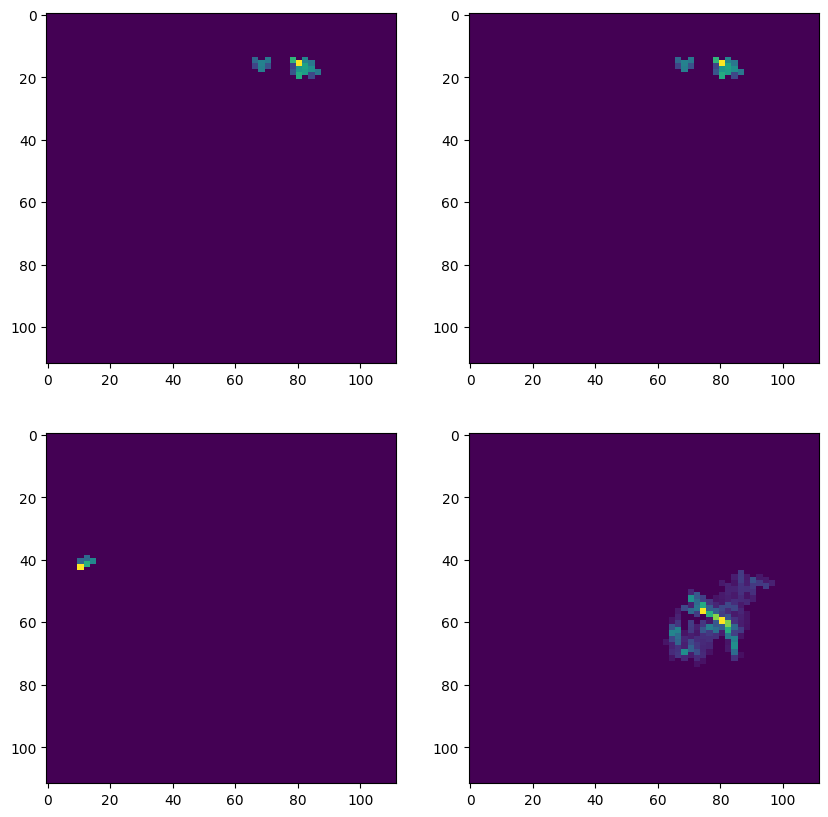

In [14]:
fig = plt.figure(figsize=(10,10))    
plt.subplot(221)
plt.imshow(np.squeeze(test_mixup[1900]))
plt.subplot(222)
plt.imshow(np.squeeze(test_mixup[1900]))
plt.subplot(223)
plt.imshow(np.squeeze(test_mixup[idx1]))
plt.subplot(224)
plt.imshow(np.squeeze(test_mixup[idx2]))

In [15]:
imgs_MST_MONO_Fe[0].shape

(112, 112, 1)

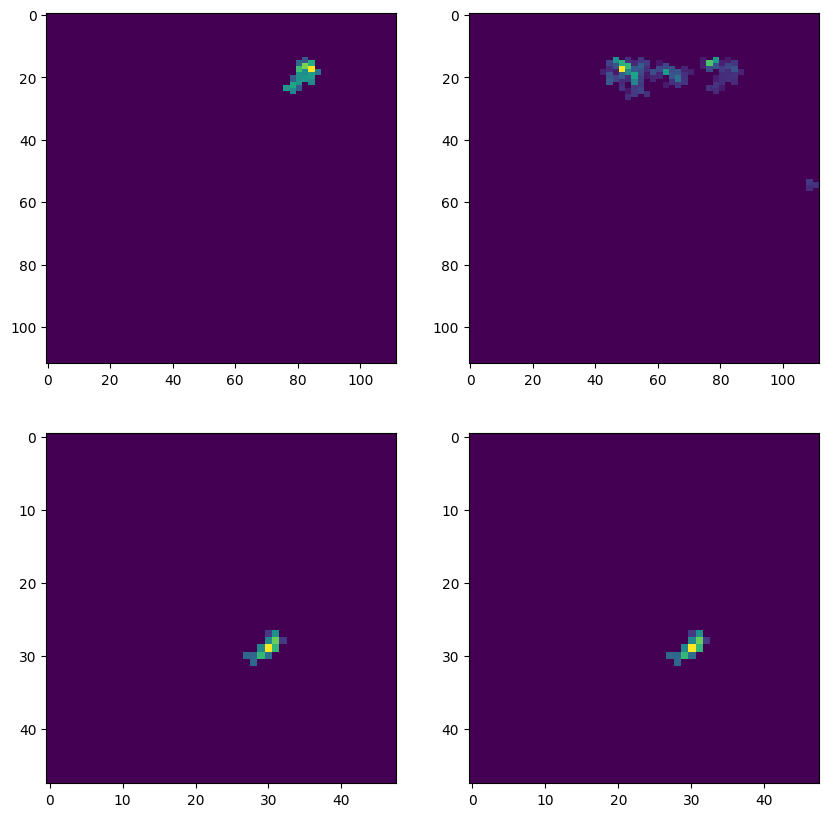

In [16]:
nx = 0
imag1 = imgs_MST_MONO_Fe
imag2 = imgs_MST_STER_Fe
imag3 = imgs_SST_MONO_Fe
imag4 = imgs_SST_STER_Fe

fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(np.squeeze(imag1[nx]))
plt.subplot(222)
plt.imshow(np.squeeze(imag2[nx]))
plt.subplot(223)
plt.imshow(np.squeeze(imag3[nx]))
plt.subplot(224)
plt.imshow(np.squeeze(imag3[nx]))
# show the plot
plt.show()

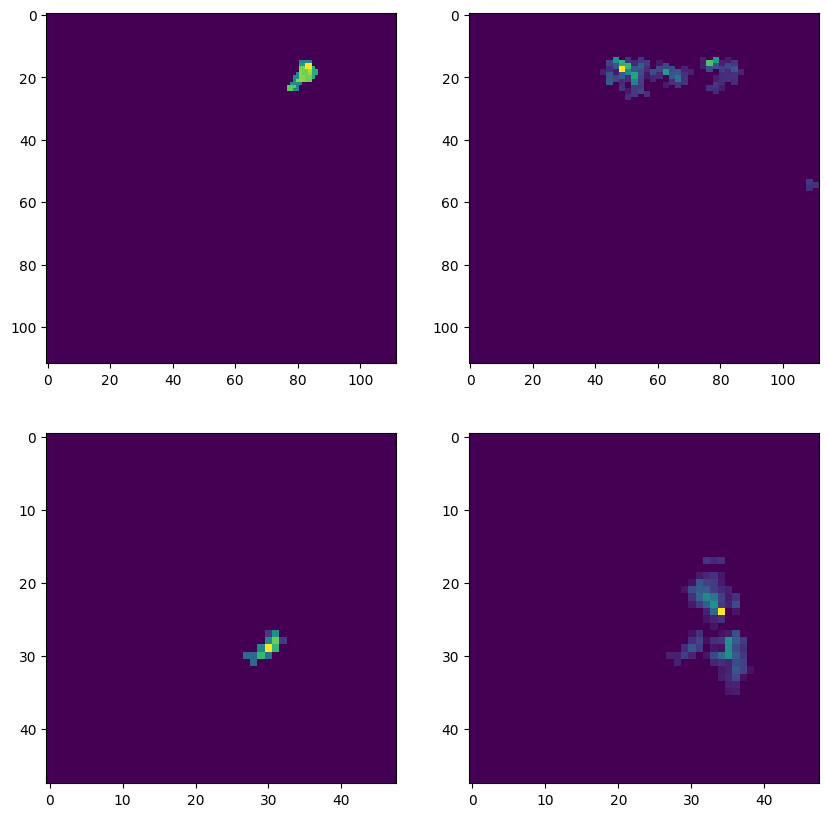

In [17]:
nx = 0
imag1 = median_filter(imgs_MST_MONO_Fe,3)
#imag2 = enhance_edges(imgs_MST_STER_Fe)
#imag3 = enhance_edges(imgs_SST_MONO_Fe)
#imag4 = enhance_edges(imgs_SST_STER_Fe)

fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(np.squeeze(imag1[nx]))
plt.subplot(222)
plt.imshow(np.squeeze(imag2[nx]))
plt.subplot(223)
plt.imshow(np.squeeze(imag3[nx]))
plt.subplot(224)
plt.imshow(np.squeeze(imag4[nx]))
# show the plot
plt.show()

In [ ]:
im = imag2[nx]
sx = sp.ndimage.sobel(im, axis=0, mode='constant')
sy = sp.ndimage.sobel(im, axis=1, mode='constant')
sob = np.hypot(sx, sy)

plt.figure(figsize=(16, 5))
plt.subplot(141)
plt.imshow(im)
plt.axis('off')
plt.title('square', fontsize=20)
plt.subplot(142)
plt.imshow(sx)
plt.axis('off')
plt.title('Sobel (x direction)', fontsize=20)
plt.subplot(143)
plt.imshow(sob)
plt.axis('off')
plt.title('Sobel filter', fontsize=20)

im += 0.07*np.random.random(im.shape)

sx = sp.ndimage.sobel(im, axis=0, mode='constant')
sy = sp.ndimage.sobel(im, axis=1, mode='constant')
sob = np.hypot(sx, sy)

plt.subplot(144)
plt.imshow(sob)
plt.axis('off')
plt.title('Sobel for noisy image', fontsize=20)



plt.subplots_adjust(wspace=0.02, hspace=0.02, top=1, bottom=0, left=0, right=0.9)

plt.show()


In [ ]:
nx = 10
imag1 = imgs_MST_MONO_p
imag2 = imgs_MST_STER_p
imag3 = imgs_SST_MONO_p
imag4 = imgs_SST_STER_p

fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(np.squeeze(imag1[nx]))
plt.subplot(222)
plt.imshow(np.squeeze(imag2[nx]))
plt.subplot(223)
plt.imshow(np.squeeze(imag3[nx]))
plt.subplot(224)
plt.imshow(np.squeeze(imag3[nx]))
# show the plot
plt.show()

# ENERGY, XMAX, Y

In [10]:
# XMAX by species
E_MST_Fe = data_MST['ENERGY'][0]
E_MST_p  = data_MST['ENERGY'][1]
XMAX_MST_Fe = data_MST['XMAX'][0]
XMAX_MST_p  = data_MST['XMAX'][1]

E_SST_Fe = data_SST['ENERGY'][0]
E_SST_p  = data_SST['ENERGY'][1]
XMAX_SST_Fe = data_SST['XMAX'][0]
XMAX_SST_p  = data_SST['XMAX'][1]

#p+Fe
E_MST_Fe_p = np.concatenate((E_MST_Fe,E_MST_p), axis=0)
E_SST_Fe_p = np.concatenate((E_SST_Fe,E_SST_p), axis=0)
XMAX_MST_Fe_p = np.concatenate((E_MST_Fe,E_MST_p), axis=0)
XMAX_SST_Fe_p = np.concatenate((E_SST_Fe,E_SST_p), axis=0)

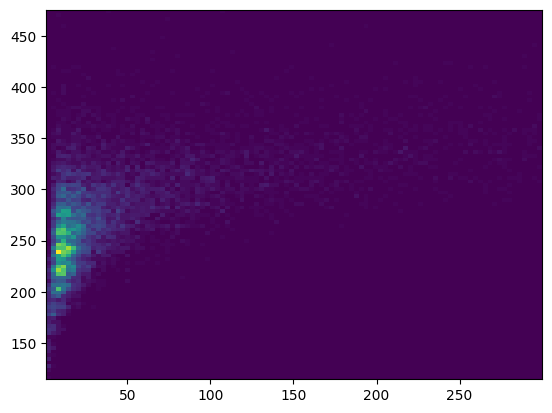

In [11]:
plt.hist2d(E_SST_Fe,XMAX_SST_Fe,bins=100)
plt.show()

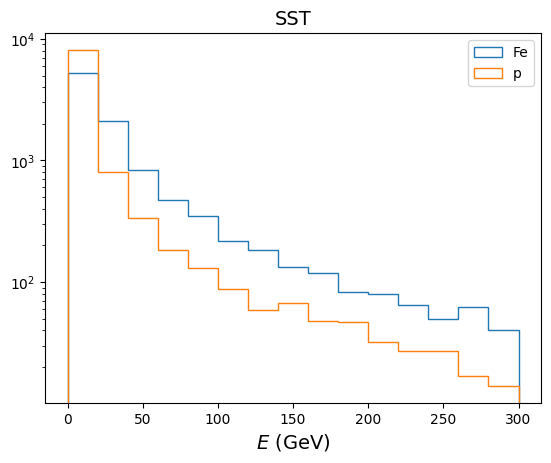

In [18]:
nbins= np.arange(0,320,20)
plt.hist(E_SST_Fe,bins=nbins,histtype='step',label='Fe')
plt.hist(E_SST_p,bins=nbins,histtype='step',label='p')
plt.legend(loc='best')
plt.xlabel(r'$E$ (GeV)',size=14)
plt.title('SST',size=14)
plt.yscale('log')
#plt.savefig('../figures/E_Fe_P_SST.pdf')
plt.show()

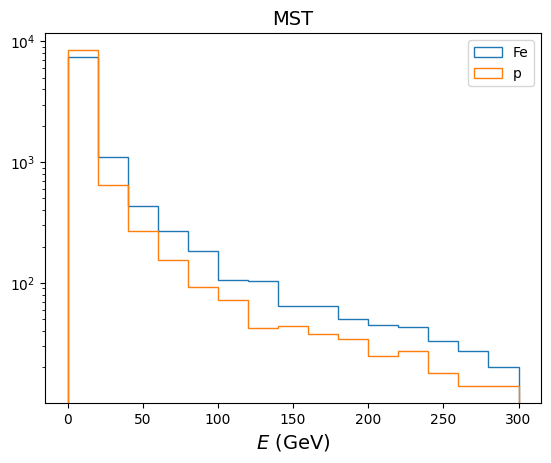

In [20]:
plt.hist(E_MST_Fe,bins=nbins,histtype='step',label='Fe')
plt.hist(E_MST_p,bins=nbins,histtype='step',label='p')
plt.legend(loc='best')
plt.xlabel(r'$E$ (GeV)',size=14)
plt.title('MST',size=14)
plt.yscale('log')
#plt.savefig('../figures/E_Fe_P_MST.pdf')
plt.show()

# VARIATIONAL AUTO-ENCODER MODEL

In [21]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def Nsampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    #thre = K.random_uniform(shape=(batch,1))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# DEEP CONVOLUTIONAL NEURAL NET

In [22]:
def DCNN(input_image,latent_dim,isVar,input_cVar,dp,n_ft,n_conv):
    
    x0 = Conv2D(n_ft, activation='relu', kernel_size=(3, 3),padding='same')(input_image)
    x0 = MaxPooling2D(pool_size=(2, 2))(x0)
    
    for k in range(n_conv):
        fac = int(2*(k+1))
        x0 = Conv2D(int(n_ft), activation='relu', kernel_size=(3, 3),padding='same')(x0)
        #x0 = BatchNormalization()(x0)
        x0 = MaxPooling2D(pool_size=(2, 2))(x0)

    x1 = Flatten()(x0)
    #if isVar:
        # Concatenate Energy
        #input_cVar = Input(shape=(1,), name='cVar')
        #xc = Dense(1, name='concat')(input_cVar)
        #x1 = Concatenate()([x1, input_cVar])
        #x1 = Flatten()(x1)
        
    #x1 = Dropout(dp)(x1)
    x1 = Dense(int(latent_dim), activation='tanh',kernel_regularizer=regularizers.l2(L2_reg))(x1)
    #x1 = Dropout(dp)(x1)
    x1 = Dense(int(latent_dim*2), activation='tanh',kernel_regularizer=regularizers.l2(L2_reg))(x1)
    x1 = Dropout(dp)(x1)
    xo = Dense(int(latent_dim*4), activation='tanh',kernel_regularizer=regularizers.l2(L2_reg))(x1)
    if isVar:
        # Concatenate Energy
        #input_cVar = Input(shape=(1,), name='cVar')
        #xc = Dense(1, name='concat')(input_cVar)
        xo = Concatenate()([xo, input_cVar])
    
    return xo

# DECODER

In [23]:
def decodeNN(latent_input,dim_img,latent_dim,n_ft,L2_reg,reco_loss):
    
    patch_x,patch_y = dim_img

    # build decoder model
    y = Dense(latent_dim*2, activation='tanh',kernel_regularizer=regularizers.l2(L2_reg))(latent_input)
    y = Dense(latent_dim*4, activation='tanh',kernel_regularizer=regularizers.l2(L2_reg))(y)
    y = Dense(int(patch_x/8*patch_y/8*n_ft*4), activation='relu',kernel_regularizer=regularizers.l2(L2_reg))(y)
    y = Reshape((int(patch_x/8),int(patch_y/8),n_ft*4))(y)
    
    y = Conv2D(n_ft*4, kernel_size=(3, 3),padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = UpSampling2D((2,2))(y)

    y = Conv2D(n_ft*2, kernel_size=(3, 3),padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = UpSampling2D((2,2))(y)

    y = Conv2D(n_ft, kernel_size=(3, 3),padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = UpSampling2D((2,2))(y)

    y = Conv2D(1, kernel_size=(3, 3),padding='same')(y)
    
    if reco_loss=='binary':
        #yo = BatchNormalization()(y)
        yo = Activation('sigmoid')(y)
    else:
        #yo = BatchNormalization()(y)
        yo = y
        
    return yo

# LATENT SPACE -- DCNN+q(z|x) = ENCODER

In [24]:
# q(z|x) neural net
def qzx(xo,latent_dim):
    
    z_mean = Dense(latent_dim*4, activation='tanh', name='z_mean_1')(xo)
    z_mean = Dense(latent_dim, activation = 'tanh', name='z_mean_2')(z_mean)
    
    z_log_var = Dense(latent_dim*4, activation='tanh', name='z_log_var_1')(xo)
    z_log_var = Dense(latent_dim, activation='tanh', name='z_log_var_2')(z_log_var)
    
    return z_mean, z_log_var

# LATENT GENERATOR

In [25]:
# latent generator (simplified)
# p(z|c) : c --> latent_dim
def latent_generator(gen_input,latent_dim):
    
    inter_z = Dense(latent_dim, activation='tanh', kernel_constraint=unit_norm(), name='inter_z_1')(gen_input)
    #inter_z_2 = Dense(int(latent_dim/2), activation='tanh', kernel_constraint=unit_norm(), name='inter_z_2')(inter_z_1)
    pz_mean = Dense(latent_dim, name='pz_mean', kernel_constraint=unit_norm())(inter_z)

    #pz_mean = Dense(latent_dim, name='pz_mean', kernel_constraint=unit_norm())(generator_input)
    pz_log_var = Dense(latent_dim, name='pz_log_var',kernel_constraint=max_norm(0))(gen_input)
    
    return pz_mean, pz_log_var

# PROBABILISTIC REGRESSORS

In [26]:
# Mean, log(r_var)
def Regressor(x1,x2,orig_dim_r,latent_dim):
    
    xo = Concatenate()([x1,x2])
    r_mean = Dense(latent_dim*8, activation='tanh', name='r_mean_1')(xo)
    #r_mean = Dropout(0.1)(r_mean)
    #r_mean = Dense(latent_dim*2, activation='tanh', name='r_mean_2')(r_mean)
    #r_mean = Dropout(0.1)(r_mean)
    r_mean = Dense(orig_dim_r, name='r_mean')(r_mean)
    
    r_log_var = Dense(latent_dim*8, activation='tanh', name='r_log_var_1')(xo)
    #r_log_var = Dropout(0.1)(r_log_var)
    #r_log_var = Dense(latent_dim*2, activation='tanh', name='r_log_var_2')(r_log_var)
    #r_log_var = Dropout(0.1)(r_log_var)
    r_log_var = Dense(orig_dim_r, name='r_log_var')(r_log_var)
    
    return r_mean, r_log_var

In [27]:
## Build VAE-Regression Model
def VAE_Reg(dim_img,dim_r,dp,L2_reg,latent_dim,reco_loss,isVar,dimVar,n_ft,n_conv):
    
    # VAE model = encoder + decoder
    patch_x,patch_y = dim_img
    input_r = Input(shape=(1, ), name='ground_truth')
    input_image = Input(shape=(patch_x,patch_y,1), name='input_image')
    
    # calling encoder model    
    x_aux = Input(shape=(dimVar,), name='Auxiliar')
    x_img = DCNN(input_image,latent_dim,isVar,input_cVar,dp,n_ft,n_conv)

    # DCNN -> q(z|x_img) = Encoder
    z_mean, z_log_var =  qzx(x_img,latent_dim)
    
    # posterior on Y; probablistic regressor
    r_mean, r_log_var = Regressor(z_mean,z_log_var,dim_r,latent_dim)

    # use reparameterization trick to push the sampling out as input
    z = Lambda(Nsampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    r = Lambda(Nsampling, output_shape=(1,), name='r')([r_mean, r_log_var])

    # instantiate encoder model
    encoder = Model([input_image,input_r,x_aux], [z_mean, z_log_var, z, r_mean, r_log_var, r], name='encoder')
    encoder.summary()
    
    # build generator model
    generator_input = Input(shape=(1,), name='generator_input')
    pz_mean, pz_log_var = latent_generator(generator_input,latent_dim)
    
    # instantiate generator model
    generator = Model(generator_input, [pz_mean,pz_log_var], name='generator')
    generator.summary()    
    
    
    # build decoder model
    latent_input = Input(shape=(latent_dim,), name='z_sampling')
    outputs = decodeNN(latent_input,dim_img,latent_dim,n_ft,L2_reg,reco_loss)

    # instantiate decoder model
    decoder = Model(latent_input, outputs, name='decoder')
    decoder.summary()
    
    # instantiate VAE model
    pz_mean,pz_log_var = generator(encoder([input_image,input_r,x_aux])[5])
    outputs = decoder(encoder([input_image,input_r,x_aux])[2])
    vae = Model([input_image,input_r,x_aux], [outputs, pz_mean,pz_log_var], name='vae_mlp')
    
    #vae.summary()
    return vae, encoder, decoder, generator, outputs, input_image, input_r, z_mean, z_log_var, z, r_mean, r_log_var, r, pz_mean, pz_log_var

In [28]:
##Customize Lost Function of the VAE Model
#models = (encoder, decoder)
def VAELoss(input_image,input_r,outputs,z_mean,z_log_var,z,r_mean,r_log_var,r,pz_mean,pz_log_var,reco_loss):

    if reco_loss=='binary':
        reconstruction_loss = K.mean(binary_crossentropy(input_image,outputs), axis=[1,2])
    elif reco_loss=='mae':
        reconstruction_loss = K.mean(mean_absolute_error(input_image,outputs), axis=[1,2])
    elif reco_loss=='mse':
        reconstruction_loss = K.mean(mse(input_image,outputs), axis=[1,2])
    #elif reco_loss=='huber':
    #    reconstruction_loss = lam*K.mean(mean_absolute_error(input_image,outputs), axis=[1,2])+(1-lam)*huber(input_image,outputs,delta=delta)

    kl_loss = 1 + z_log_var - pz_log_var - tf.math.divide(K.square(z_mean-pz_mean),K.exp(pz_log_var)) - tf.math.divide(K.exp(z_log_var),K.exp(pz_log_var))
    kl_loss = -0.5*K.sum(kl_loss, axis=-1)
    label_loss = tf.math.divide(0.5*K.square(r_mean - input_r), K.exp(r_log_var)) +  0.5 * r_log_var

    beta = 1.25
    vae_loss = K.mean(reconstruction_loss+kl_loss+beta*label_loss)
    
    return vae_loss

# SETTING THE PARAMETERS

In [47]:
# PARTICLE AND CASE
part = 'p+Fe'
caso = 'SST-MONO-'

# Setting the Hyperparameters
## CNN Parameters 
# Drop out
dp = 0.2
# Number of Filters
n_ft = 24
# Number of Conv Layers
n_conv = 3
# Dimension of the Latent Space
latent_dim = 24
# L2 regularization
L2_reg= 0
# Learning Rate
lr = 2e-3
# Epochs
epochs = 200
# batch size
batch_size = 64

# VAE-Loss
reco_loss = 'binary'

# augmentation/transfromation of images
isAug = False #True
isFlip= False
isEdge= False
aug_size = 3000

# auxiliary variable
isVar = False
#aux_file = '../data/image_features_SST_MONO_Fe_p.csv'
#yX = aux_features(aux_file)[:,:-2]
#n_aux = yX.shape[1]
n_aux = 6
print(n_aux)

6


# TRAIN/TEST SPLIT

In [49]:
dim_r = 1

if part=='p':
    caso = caso+part
    fold = 'Energy/Proton/'
elif part=='Fe':
    caso = caso+part
    
    fold = 'Energy/Iron/'
elif part=='p+Fe':
    caso = caso+part
    fold = 'Energy/Iron+Proton/'

if caso=='SST-MONO-Fe':
    leg = r'Iron, $48\times 48$, Mono'
    data_images = normalize_img(imgs_SST_MONO_Fe)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_SST_Fe)
    yX = XMAX_SST_Fe
    #yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    
elif caso=='SST-STER-Fe':
    leg = r'Iron, $48\times 48$, Stereo'
    data_images = normalize_img(imgs_SST_STER_Fe)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_SST_Fe)
    yX = XMAX_SST_Fe
    #yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    
elif caso=='MST-MONO-Fe':
    leg = r'Iron, $112\times 112$, Mono'
    data_images = normalize_img(imgs_MST_MONO_Fe)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_MST_Fe)
    yX = XMAX_MST_Fe
    #yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    
elif caso=='MST-STER-Fe':
    leg = r'Iron, $112\times 112$, Stereo'
    data_images = normalize_img(imgs_MST_STER_Fe)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_MST_Fe)
    yX = XMAX_MST_Fe
    #yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    
elif caso=='SST-MONO-p':
    leg = r'Proton, $48\times 48$, Mono'
    data_images = normalize_img(imgs_SST_MONO_p)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_SST_p)
    yX = XMAX_SST_p
    #yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    
elif caso=='SST-STER-p':
    leg = r'Proton, $48\times 48$, Stereo'
    data_images = normalize_img(imgs_SST_STER_p)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_SST_p)
    yX = XMAX_SST_p
    #yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    
elif caso=='MST-MONO-p':
    leg = r'Proton, $112\times 112$, Mono'
    data_images = normalize_img(imgs_MST_MONO_p)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_MST_p)
    yX = XMAX_MST_p
    #yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    
elif caso=='MST-STER-p':
    leg = r'Proton, $112\times 112$, Stereo'
    data_images = normalize_img(imgs_MST_STER_p)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_MST_p) 
    yX = XMAX_MST_p
    #yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    
elif caso=='SST-MONO-p+Fe':
    leg = r'Iron+Proton, $48\times 48$, Mono'
    data_images = normalize_img(imgs_SST_MONO_Fe_p)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_SST_Fe_p)
    yX = XMAX_SST_Fe_p
    #yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    
elif caso=='SST-STER-p+Fe':
    leg = r'Iron+Proton, $48\times 48$, Stereo'
    data_images = normalize_img(imgs_SST_STER_Fe_p)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_SST_Fe_p)
    yX = XMAX_SST_Fe_p
    #yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    
elif caso=='MST-MONO-p+Fe':
    leg = r'Iron+Proton, $112\times 112$, Mono'
    data_images = normalize_img(imgs_MST_MONO_Fe_p)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_MST_Fe_p)
    yX = XMAX_MST_Fe_p
    #yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    
elif caso=='MST-STER-p+Fe':
    leg = r'Iron+Proton, $112\times 112$, Stereo'
    data_images = normalize_img(imgs_MST_STER_Fe_p)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_MST_Fe_p)
    yX = XMAX_MST_Fe_p
    #yX = aux_features(aux_file)[:,:-2] #not including E,Xmax

print(caso, dim_img, dim_r)
fake = np.zeros((data_images.shape[0]))
pred = np.zeros((yE.shape))

SST-MONO-p+Fe [48, 48] 1


In [50]:
def conv(arg):
    arg = tf.convert_to_tensor(arg, dtype=tf.float32)
    return arg

In [51]:
# Train/Test split
rs = 42
if isEdge:
    #data_images = median_filter(data_images,2)
    data_images = enhance_edges(data_images)
    
train_data, test_data, train_e, test_e = train_test_split(data_images,yE,test_size=0.33,shuffle=True,random_state=rs)
_, _, train_xmax, test_xmax = train_test_split(data_images,yX,test_size=0.33,shuffle=True,random_state=rs)
train_xmax = conv(train_xmax)
input_cVar = conv(train_xmax)

# augment data
if isAug:
    caso = caso+'-aug'
    #train_data_aug, train_e_aug = augment_by_transformation(train_data,train_e,augment_size,isFlip,1)
    train_data_aug, train_e_aug = augment_mixup(train_data,train_e,aug_size,1)
    train_e_aug = conv(train_e_aug)
    input_cVar = conv(train_e_aug)
    if isVar:
        caso = caso+'-xmax'
        _, train_xmax_aug = augment_mixup(train_data,train_xmax,aug_size,n_aux)
        train_xmax_aug = conv(train_xmax_aug)
        input_cVar = conv(train_xmax_aug)

# auxiliary variable
if not isAug and isVar:
    caso = caso+'-xmax'
    _, _, train_xmax, test_xmax = train_test_split(data_images,yX,test_size=0.2,shuffle=True,random_state=rs)
    train_xmax = conv(train_xmax)
    input_cVar = conv(train_xmax)

In [53]:
#print(train_data.shape,train_data_aug.shape)
#print(train_e_aug.shape)

In [56]:
## Train the network
#for train_idx, test_idx in skf.split(data_images, fake):
    
    #print(train_idx)
    
#    train_data = data_images[train_idx]
#    train_e = np.log(yE[train_idx])

#    test_data = data_images[test_idx]
#    test_e = np.log(yE[test_idx])

checkpoint_filepath = 'VAE/'+fold+'e_best_weights_'+caso+'.h5' 
model_checkpoint_callback = ModelCheckpoint(
                    filepath=checkpoint_filepath,
                    save_weights_only=True,
                    monitor='val_loss',
                    mode='min',
                    save_best_only=True)

# instantiate the model
vae,encoder,decoder,generator,outputs,input_image,input_r,z_mean,z_log_var,z,r_mean,r_log_var,r,pz_mean,pz_log_var = VAE_Reg(dim_img,dim_r,dp,L2_reg,latent_dim,reco_loss,isVar,n_aux,n_ft,n_conv)

# Computing the Loss Function
vae_loss = VAELoss(input_image,input_r,outputs,z_mean,z_log_var,z,r_mean,r_log_var,r,
                   pz_mean,pz_log_var,reco_loss)
vae.add_loss(vae_loss)

######################################
#step = tf.Variable(0, trainable=False)
#schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
#    [200, 400, 600, 800], [1.0, 0.5, 0.25, 0.125, 0.0625])
# lr and wd can be a function or a tensor
#lr = 1e-3 #* schedule(step)
#wd = lambda: 1e-2 * schedule(step)
#loss_fn = mse
opt = Adam(learning_rate=lr) #'adam'
#opt = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
reduce_lr = ReduceLROnPlateau(monitor='lr', factor=0.5,
                              patience=20, min_lr=1e-8)



########## Early stopping
stop = EarlyStopping(monitor='val_loss', mode='min', patience=25)

######################################
# Compilatio
vae.compile(optimizer=opt, metrics=['mae', 'mse'])
vae.summary()
#vae.save_weights('../models/vae_dnn_weights.hdf5')

if isAug:
    train_x = train_data_aug
    train_y = train_e_aug
else:
    train_x = train_data
    train_y = train_e
    
history=vae.fit([train_x,train_y,input_cVar],
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[model_checkpoint_callback, reduce_lr, stop], #,TensorBoard(log_dir='/tmp/autoencoder')],
                validation_split = 0.25,
                #validation_data=([X_valid, Y_valid]),
                verbose = 1)

vae.save_weights('VAE/'+fold+'e_vae_weights_'+caso+'.h5')
encoder.save_weights('VAE/'+fold+'e_encoder_weights_'+caso+'.h5')
#generator.save_weights('../models/'+fold+'e_generator_weights_'+caso+'.h5')
#decoder.save_weights('../models/'+fold+'e_decoder_weights_'+caso+'.h5')

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 48, 48, 24)   240         ['input_image[0][0]']            
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 24, 24, 24)  0           ['conv2d_16[0][0]']              
                                                                                                  
 conv2d_17 (Conv2D)             (None, 24, 24, 24)   5208        ['max_pooling2d_8[0][0]']        
                                                                                            

Epoch 1/200
158/158 [==============================] - 5s 13ms/step - loss: 1.4945 - decoder_mae: 0.0000e+00 - decoder_mse: 0.0000e+00 - generator_mae: 0.0000e+00 - generator_mse: 0.0000e+00 - generator_1_mae: 0.0000e+00 - generator_1_mse: 0.0000e+00 - val_loss: 0.9550 - val_decoder_mae: 0.0000e+00 - val_decoder_mse: 0.0000e+00 - val_generator_mae: 0.0000e+00 - val_generator_mse: 0.0000e+00 - val_generator_1_mae: 0.0000e+00 - val_generator_1_mse: 0.0000e+00 - lr: 0.0020
Epoch 2/200
158/158 [==============================] - 2s 10ms/step - loss: 0.9587 - decoder_mae: 0.0000e+00 - decoder_mse: 0.0000e+00 - generator_mae: 0.0000e+00 - generator_mse: 0.0000e+00 - generator_1_mae: 0.0000e+00 - generator_1_mse: 0.0000e+00 - val_loss: 0.9309 - val_decoder_mae: 0.0000e+00 - val_decoder_mse: 0.0000e+00 - val_generator_mae: 0.0000e+00 - val_generator_mse: 0.0000e+00 - val_generator_1_mae: 0.0000e+00 - val_generator_1_mse: 0.0000e+00 - lr: 0.0020
Epoch 3/200
158/158 [=============================

158/158 [==============================] - 2s 10ms/step - loss: 0.8813 - decoder_mae: 0.0000e+00 - decoder_mse: 0.0000e+00 - generator_mae: 0.0000e+00 - generator_mse: 0.0000e+00 - generator_1_mae: 0.0000e+00 - generator_1_mse: 0.0000e+00 - val_loss: 0.9036 - val_decoder_mae: 0.0000e+00 - val_decoder_mse: 0.0000e+00 - val_generator_mae: 0.0000e+00 - val_generator_mse: 0.0000e+00 - val_generator_1_mae: 0.0000e+00 - val_generator_1_mse: 0.0000e+00 - lr: 0.0020
Epoch 13/200
158/158 [==============================] - 2s 10ms/step - loss: 0.8773 - decoder_mae: 0.0000e+00 - decoder_mse: 0.0000e+00 - generator_mae: 0.0000e+00 - generator_mse: 0.0000e+00 - generator_1_mae: 0.0000e+00 - generator_1_mse: 0.0000e+00 - val_loss: 0.9223 - val_decoder_mae: 0.0000e+00 - val_decoder_mse: 0.0000e+00 - val_generator_mae: 0.0000e+00 - val_generator_mse: 0.0000e+00 - val_generator_1_mae: 0.0000e+00 - val_generator_1_mse: 0.0000e+00 - lr: 0.0020
Epoch 14/200
158/158 [==============================] - 2s 10

158/158 [==============================] - 2s 10ms/step - loss: 0.6656 - decoder_mae: 0.0000e+00 - decoder_mse: 0.0000e+00 - generator_mae: 0.0000e+00 - generator_mse: 0.0000e+00 - generator_1_mae: 0.0000e+00 - generator_1_mse: 0.0000e+00 - val_loss: 0.7995 - val_decoder_mae: 0.0000e+00 - val_decoder_mse: 0.0000e+00 - val_generator_mae: 0.0000e+00 - val_generator_mse: 0.0000e+00 - val_generator_1_mae: 0.0000e+00 - val_generator_1_mse: 0.0000e+00 - lr: 0.0010
Epoch 30/200
158/158 [==============================] - 2s 10ms/step - loss: 0.6410 - decoder_mae: 0.0000e+00 - decoder_mse: 0.0000e+00 - generator_mae: 0.0000e+00 - generator_mse: 0.0000e+00 - generator_1_mae: 0.0000e+00 - generator_1_mse: 0.0000e+00 - val_loss: 0.7107 - val_decoder_mae: 0.0000e+00 - val_decoder_mse: 0.0000e+00 - val_generator_mae: 0.0000e+00 - val_generator_mse: 0.0000e+00 - val_generator_1_mae: 0.0000e+00 - val_generator_1_mse: 0.0000e+00 - lr: 0.0010
Epoch 31/200
158/158 [==============================] - 2s 10

158/158 [==============================] - 2s 10ms/step - loss: 0.5387 - decoder_mae: 0.0000e+00 - decoder_mse: 0.0000e+00 - generator_mae: 0.0000e+00 - generator_mse: 0.0000e+00 - generator_1_mae: 0.0000e+00 - generator_1_mse: 0.0000e+00 - val_loss: 0.6901 - val_decoder_mae: 0.0000e+00 - val_decoder_mse: 0.0000e+00 - val_generator_mae: 0.0000e+00 - val_generator_mse: 0.0000e+00 - val_generator_1_mae: 0.0000e+00 - val_generator_1_mse: 0.0000e+00 - lr: 5.0000e-04
Epoch 47/200
158/158 [==============================] - 2s 10ms/step - loss: 0.5329 - decoder_mae: 0.0000e+00 - decoder_mse: 0.0000e+00 - generator_mae: 0.0000e+00 - generator_mse: 0.0000e+00 - generator_1_mae: 0.0000e+00 - generator_1_mse: 0.0000e+00 - val_loss: 0.6949 - val_decoder_mae: 0.0000e+00 - val_decoder_mse: 0.0000e+00 - val_generator_mae: 0.0000e+00 - val_generator_mse: 0.0000e+00 - val_generator_1_mae: 0.0000e+00 - val_generator_1_mse: 0.0000e+00 - lr: 5.0000e-04
Epoch 48/200
158/158 [==============================]

158/158 [==============================] - 2s 10ms/step - loss: 0.4855 - decoder_mae: 0.0000e+00 - decoder_mse: 0.0000e+00 - generator_mae: 0.0000e+00 - generator_mse: 0.0000e+00 - generator_1_mae: 0.0000e+00 - generator_1_mse: 0.0000e+00 - val_loss: 0.8106 - val_decoder_mae: 0.0000e+00 - val_decoder_mse: 0.0000e+00 - val_generator_mae: 0.0000e+00 - val_generator_mse: 0.0000e+00 - val_generator_1_mae: 0.0000e+00 - val_generator_1_mse: 0.0000e+00 - lr: 5.0000e-04


In [63]:
## Train the network
#for train_idx, test_idx in skf.split(data_images, fake):
    
    #print(train_idx)
    
#    train_data = data_images[train_idx]
#    train_e = np.log(yE[train_idx])

#    test_data = data_images[test_idx]
#    test_e = np.log(yE[test_idx])

checkpoint_filepath = '../models/'+fold+'e_best_weights_'+caso+'.h5' 
model_checkpoint_callback = ModelCheckpoint(
                    filepath=checkpoint_filepath,
                    save_weights_only=True,
                    monitor='val_loss',
                    mode='min',
                    save_best_only=True)

# instantiate the model
vae,encoder,decoder,generator,outputs,input_image,input_r,z_mean,z_log_var,z,r_mean,r_log_var,r,pz_mean,pz_log_var = VAE_Reg(dim_img,dim_r,dp,L2_reg,latent_dim,reco_loss,isVar,n_aux,n_ft,n_conv)

# Computing the Loss Function
vae_loss = VAELoss(input_image,input_r,outputs,z_mean,z_log_var,z,r_mean,r_log_var,r,
                   pz_mean,pz_log_var,reco_loss)
vae.add_loss(vae_loss)

######################################
#step = tf.Variable(0, trainable=False)
#schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
#    [200, 400, 600, 800], [1.0, 0.5, 0.25, 0.125, 0.0625])
# lr and wd can be a function or a tensor
#lr = 1e-3 #* schedule(step)
#wd = lambda: 1e-2 * schedule(step)
#loss_fn = mse
opt = Adam(learning_rate=lr) #'adam'
#opt = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
reduce_lr = ReduceLROnPlateau(monitor='lr', factor=0.5,
                              patience=20, min_lr=1e-8)



########## Early stopping
stop = EarlyStopping(monitor='val_loss', mode='min', patience=25)

######################################
# Compilatio
vae.compile(optimizer=opt, metrics=['mae', 'mse'])
vae.summary()
#vae.save_weights('../models/vae_dnn_weights.hdf5')

if isAug:
    train_x = train_data_aug
    train_y = train_e_aug
else:
    train_x = train_data
    train_y = train_e
    
history=vae.fit([train_x,train_y,input_cVar],
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[model_checkpoint_callback, reduce_lr, stop], #,TensorBoard(log_dir='/tmp/autoencoder')],
                validation_split = 0.25,
                #validation_data=([X_valid, Y_valid]),
                verbose = 1)

vae.save_weights('../models/'+fold+'e_vae_weights_'+caso+'.h5')
encoder.save_weights('../models/'+fold+'e_encoder_weights_'+caso+'.h5')
#generator.save_weights('../models/'+fold+'e_generator_weights_'+caso+'.h5')
#decoder.save_weights('../models/'+fold+'e_decoder_weights_'+caso+'.h5')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 48, 48, 24)   240         input_image[0][0]                
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 24, 24, 24)   0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 24, 24, 24)   5208        max_pooling2d_8[0][0]            
____________________________________________________________________________________________

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
ground_truth (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
Auxiliar (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 24), (None,  69458       input_image[0][0]                
                                                                 ground_truth[0][0]         

65/65 [==============================] - 16s 221ms/step - loss: 2.2527 - decoder_mae: 0.0000e+00 - decoder_mse: 0.0000e+00 - generator_mae: 0.0000e+00 - generator_mse: 0.0000e+00 - generator_1_mae: 0.0000e+00 - generator_1_mse: 0.0000e+00 - val_loss: 1.0373 - val_decoder_mae: 0.0000e+00 - val_decoder_mse: 0.0000e+00 - val_generator_mae: 0.0000e+00 - val_generator_mse: 0.0000e+00 - val_generator_1_mae: 0.0000e+00 - val_generator_1_mse: 0.0000e+00
Epoch 2/200
65/65 [==============================] - 14s 217ms/step - loss: 0.9922 - decoder_mae: 0.0000e+00 - decoder_mse: 0.0000e+00 - generator_mae: 0.0000e+00 - generator_mse: 0.0000e+00 - generator_1_mae: 0.0000e+00 - generator_1_mse: 0.0000e+00 - val_loss: 0.9490 - val_decoder_mae: 0.0000e+00 - val_decoder_mse: 0.0000e+00 - val_generator_mae: 0.0000e+00 - val_generator_mse: 0.0000e+00 - val_generator_1_mae: 0.0000e+00 - val_generator_1_mse: 0.0000e+00
Epoch 3/200
65/65 [==============================] - 14s 217ms/step - loss: 0.9667 - dec

Epoch 31/200
65/65 [==============================] - 14s 212ms/step - loss: 0.6837 - decoder_mae: 0.0000e+00 - decoder_mse: 0.0000e+00 - generator_mae: 0.0000e+00 - generator_mse: 0.0000e+00 - generator_1_mae: 0.0000e+00 - generator_1_mse: 0.0000e+00 - val_loss: 0.6711 - val_decoder_mae: 0.0000e+00 - val_decoder_mse: 0.0000e+00 - val_generator_mae: 0.0000e+00 - val_generator_mse: 0.0000e+00 - val_generator_1_mae: 0.0000e+00 - val_generator_1_mse: 0.0000e+00
Epoch 32/200
65/65 [==============================] - 14s 212ms/step - loss: 0.6655 - decoder_mae: 0.0000e+00 - decoder_mse: 0.0000e+00 - generator_mae: 0.0000e+00 - generator_mse: 0.0000e+00 - generator_1_mae: 0.0000e+00 - generator_1_mse: 0.0000e+00 - val_loss: 0.6793 - val_decoder_mae: 0.0000e+00 - val_decoder_mse: 0.0000e+00 - val_generator_mae: 0.0000e+00 - val_generator_mse: 0.0000e+00 - val_generator_1_mae: 0.0000e+00 - val_generator_1_mse: 0.0000e+00
Epoch 33/200
65/65 [==============================] - 14s 212ms/step - los

Epoch 49/200
65/65 [==============================] - 14s 214ms/step - loss: 0.6248 - decoder_mae: 0.0000e+00 - decoder_mse: 0.0000e+00 - generator_mae: 0.0000e+00 - generator_mse: 0.0000e+00 - generator_1_mae: 0.0000e+00 - generator_1_mse: 0.0000e+00 - val_loss: 0.6181 - val_decoder_mae: 0.0000e+00 - val_decoder_mse: 0.0000e+00 - val_generator_mae: 0.0000e+00 - val_generator_mse: 0.0000e+00 - val_generator_1_mae: 0.0000e+00 - val_generator_1_mse: 0.0000e+00
Epoch 50/200
65/65 [==============================] - 14s 214ms/step - loss: 0.5948 - decoder_mae: 0.0000e+00 - decoder_mse: 0.0000e+00 - generator_mae: 0.0000e+00 - generator_mse: 0.0000e+00 - generator_1_mae: 0.0000e+00 - generator_1_mse: 0.0000e+00 - val_loss: 0.6232 - val_decoder_mae: 0.0000e+00 - val_decoder_mse: 0.0000e+00 - val_generator_mae: 0.0000e+00 - val_generator_mse: 0.0000e+00 - val_generator_1_mae: 0.0000e+00 - val_generator_1_mse: 0.0000e+00
Epoch 51/200
65/65 [==============================] - 14s 216ms/step - los

Epoch 67/200
65/65 [==============================] - 14s 213ms/step - loss: 0.4948 - decoder_mae: 0.0000e+00 - decoder_mse: 0.0000e+00 - generator_mae: 0.0000e+00 - generator_mse: 0.0000e+00 - generator_1_mae: 0.0000e+00 - generator_1_mse: 0.0000e+00 - val_loss: 0.5657 - val_decoder_mae: 0.0000e+00 - val_decoder_mse: 0.0000e+00 - val_generator_mae: 0.0000e+00 - val_generator_mse: 0.0000e+00 - val_generator_1_mae: 0.0000e+00 - val_generator_1_mse: 0.0000e+00
Epoch 68/200
65/65 [==============================] - 14s 212ms/step - loss: 0.4921 - decoder_mae: 0.0000e+00 - decoder_mse: 0.0000e+00 - generator_mae: 0.0000e+00 - generator_mse: 0.0000e+00 - generator_1_mae: 0.0000e+00 - generator_1_mse: 0.0000e+00 - val_loss: 0.5585 - val_decoder_mae: 0.0000e+00 - val_decoder_mse: 0.0000e+00 - val_generator_mae: 0.0000e+00 - val_generator_mse: 0.0000e+00 - val_generator_1_mae: 0.0000e+00 - val_generator_1_mse: 0.0000e+00
Epoch 69/200
65/65 [==============================] - 14s 213ms/step - los

Epoch 85/200
65/65 [==============================] - 14s 215ms/step - loss: 0.4200 - decoder_mae: 0.0000e+00 - decoder_mse: 0.0000e+00 - generator_mae: 0.0000e+00 - generator_mse: 0.0000e+00 - generator_1_mae: 0.0000e+00 - generator_1_mse: 0.0000e+00 - val_loss: 0.5407 - val_decoder_mae: 0.0000e+00 - val_decoder_mse: 0.0000e+00 - val_generator_mae: 0.0000e+00 - val_generator_mse: 0.0000e+00 - val_generator_1_mae: 0.0000e+00 - val_generator_1_mse: 0.0000e+00
Epoch 86/200
65/65 [==============================] - 14s 216ms/step - loss: 0.4109 - decoder_mae: 0.0000e+00 - decoder_mse: 0.0000e+00 - generator_mae: 0.0000e+00 - generator_mse: 0.0000e+00 - generator_1_mae: 0.0000e+00 - generator_1_mse: 0.0000e+00 - val_loss: 0.5769 - val_decoder_mae: 0.0000e+00 - val_decoder_mse: 0.0000e+00 - val_generator_mae: 0.0000e+00 - val_generator_mse: 0.0000e+00 - val_generator_1_mae: 0.0000e+00 - val_generator_1_mse: 0.0000e+00
Epoch 87/200
65/65 [==============================] - 14s 213ms/step - los

Epoch 103/200
65/65 [==============================] - 14s 216ms/step - loss: 0.3832 - decoder_mae: 0.0000e+00 - decoder_mse: 0.0000e+00 - generator_mae: 0.0000e+00 - generator_mse: 0.0000e+00 - generator_1_mae: 0.0000e+00 - generator_1_mse: 0.0000e+00 - val_loss: 0.6052 - val_decoder_mae: 0.0000e+00 - val_decoder_mse: 0.0000e+00 - val_generator_mae: 0.0000e+00 - val_generator_mse: 0.0000e+00 - val_generator_1_mae: 0.0000e+00 - val_generator_1_mse: 0.0000e+00
Epoch 104/200
65/65 [==============================] - 14s 222ms/step - loss: 0.3867 - decoder_mae: 0.0000e+00 - decoder_mse: 0.0000e+00 - generator_mae: 0.0000e+00 - generator_mse: 0.0000e+00 - generator_1_mae: 0.0000e+00 - generator_1_mse: 0.0000e+00 - val_loss: 0.5749 - val_decoder_mae: 0.0000e+00 - val_decoder_mse: 0.0000e+00 - val_generator_mae: 0.0000e+00 - val_generator_mse: 0.0000e+00 - val_generator_1_mae: 0.0000e+00 - val_generator_1_mse: 0.0000e+00
Epoch 105/200
65/65 [==============================] - 14s 220ms/step - 

Epoch 121/200
65/65 [==============================] - 14s 219ms/step - loss: 0.3532 - decoder_mae: 0.0000e+00 - decoder_mse: 0.0000e+00 - generator_mae: 0.0000e+00 - generator_mse: 0.0000e+00 - generator_1_mae: 0.0000e+00 - generator_1_mse: 0.0000e+00 - val_loss: 0.6232 - val_decoder_mae: 0.0000e+00 - val_decoder_mse: 0.0000e+00 - val_generator_mae: 0.0000e+00 - val_generator_mse: 0.0000e+00 - val_generator_1_mae: 0.0000e+00 - val_generator_1_mse: 0.0000e+00
Epoch 122/200
65/65 [==============================] - 14s 219ms/step - loss: 0.3712 - decoder_mae: 0.0000e+00 - decoder_mse: 0.0000e+00 - generator_mae: 0.0000e+00 - generator_mse: 0.0000e+00 - generator_1_mae: 0.0000e+00 - generator_1_mse: 0.0000e+00 - val_loss: 0.5684 - val_decoder_mae: 0.0000e+00 - val_decoder_mse: 0.0000e+00 - val_generator_mae: 0.0000e+00 - val_generator_mse: 0.0000e+00 - val_generator_1_mae: 0.0000e+00 - val_generator_1_mse: 0.0000e+00
Epoch 123/200
65/65 [==============================] - 14s 221ms/step - 

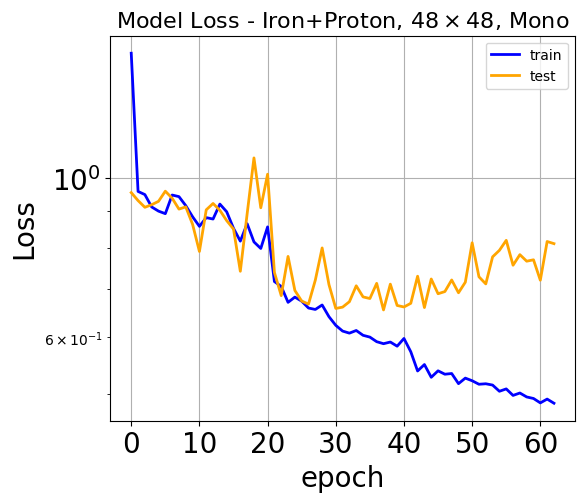

In [57]:
plt.figure(figsize=(6,5))
plt.plot(history.history['loss'], lw=2, color='blue')
plt.plot(history.history['val_loss'], lw=2, color='orange')
plt.title('Model Loss - '+leg,size=16)
plt.ylabel('Loss',size=20)
plt.xlabel('epoch',size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.grid(True)
plt.yscale('log')
plt.legend(['train','test'], loc='best')
plt.rc('legend',fontsize=14) 
#plt.savefig('../figures/'+fold+'e_loss_vae_'+caso+'.pdf')
plt.show()

In [58]:
vae.load_weights('VAE/'+fold+'e_best_weights_'+caso+'.h5')
vae.compile(optimizer=opt)

#encoder.load_weights('../models/'+fold+'e_encoder_weights_'+caso+'.h5')
#encoder.compile(optimizer=opt)

# testing
[z_mean, z_log_var, z, r_mean, r_log_var, r_vae] = encoder.predict([test_data,test_e,test_xmax],batch_size=batch_size)
ypred = r_vae[:,0]

#filename = 'prmean_squared_error(test_e,ypred)ediction_'+str(dp)+'_'+str(L2_reg)+'.npy'
#np.save(filename,pred)
rMSE_test = np.sqrt(mean_squared_error(test_e,ypred))
R2_test = r2_score(test_e, ypred)
## CC accuracy

print("rMSE: ",rMSE_test)
print("R2: ",R2_test)

rMSE:  1.422423770452878
R2:  -0.1708141337959337


In [59]:
# chi squared
def chi2(a,b):
    return np.sum((a-b)**2/a)

In [60]:
for dbin in range(200,20,-20):
    nbins = np.arange(0,300+dbin,dbin)
    a,_ = np.histogram(np.exp(test_e),bins=nbins)
    b,_ = np.histogram(np.exp(ypred),bins=nbins)
    x2pdof = chi2(a,b)/len(a)
    print(dbin,x2pdof)

200 6.750028421700932
180 11.663083422109768
160 16.339382561535253
140 28.998510260791488
120 13.631179377593924
100 17.913985627699464
80 12.56609442792288
60 12.034114644672147
40 7.3637601302898155


In [61]:
dbin=60
nbins = np.arange(0,300+dbin,dbin)
a,_ = np.histogram(np.exp(test_e),bins=nbins)
b,_ = np.histogram(np.exp(ypred),bins=nbins)
x2pdof = chi2(a,b)/len(a)

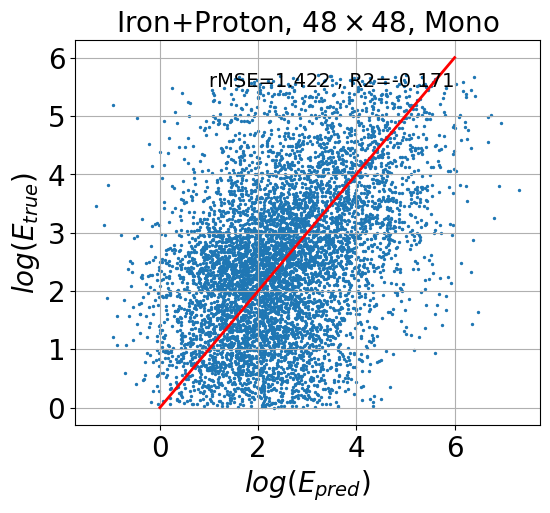

In [62]:
plt.figure(figsize=(6,5))
plt.scatter(ypred, test_e, s=2)
plt.plot([0,6],[0,6],lw=2,color='red')
#plt.xlim([0,11])
#plt.ylim([0,11])
plt.grid(True)
plt.xlabel(r'$log(E_{pred})$',size=20)
plt.ylabel(r'$log(E_{true})$',size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.text(1,5.5,"rMSE=%.3f , R2=%.3f"%(rMSE_test,R2_test),size=14)
plt.title(leg,size=20)
#plt.savefig('../figures/'+fold+'e_true_pred_vae_'+caso+'.pdf')
plt.show()

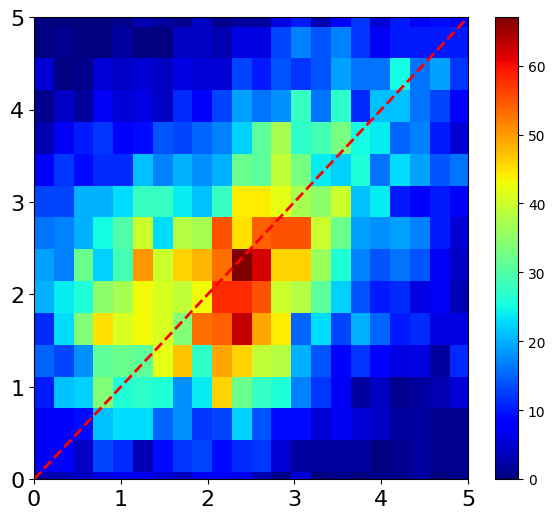

In [63]:
plt.figure(figsize=(7,6))
plt.hist2d(test_e,ypred, bins=(25,25), cmap=plt.cm.jet)
plt.plot([0,5],[0,5],lw=2,color='red',linestyle='--')
plt.xlim([0,5])
plt.ylim([0,5])
plt.xticks(size=16)
plt.yticks(size=16)
plt.colorbar()
plt.show()

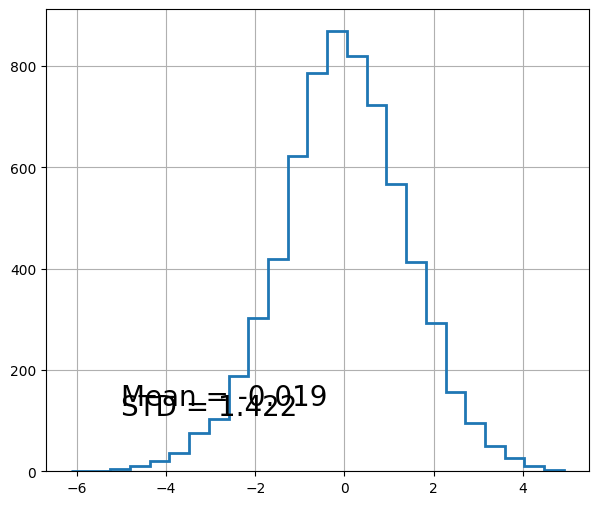

In [64]:
diff = ypred-test_e
mdiff, sdiff = np.mean(diff), np.std(diff)
plt.figure(figsize=(7,6))
plt.hist(diff,bins=25,lw=2,histtype='step')
plt.text(-5,130, r'Mean = %.3f'%(mdiff),size=20)
plt.text(-5,110, r'STD = %.3f'%(sdiff),size=20)
plt.grid(True)
plt.show()

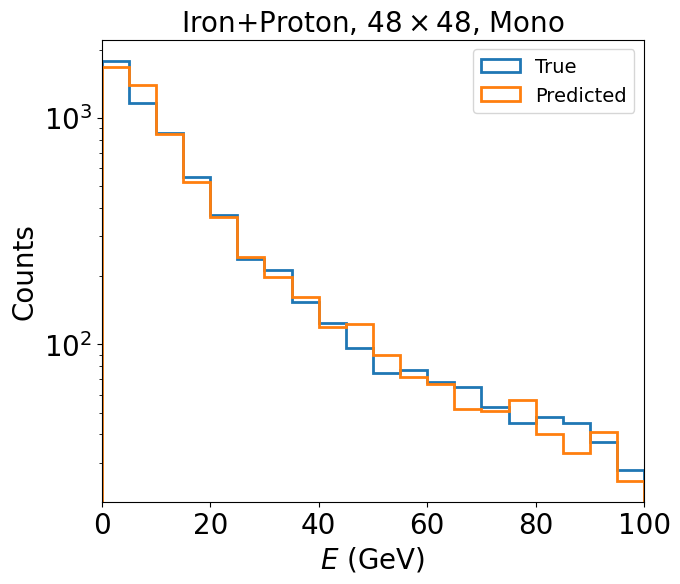

In [65]:
nbins = np.arange(0,105,5)

plt.figure(figsize=(7,6))
plt.hist(np.exp(test_e),bins=nbins,lw=2,histtype='step',label='True')
plt.hist(np.exp(ypred),bins=nbins,lw=2,histtype='step',label='Predicted')
plt.xlabel(r'$E$ (GeV)',size=20)
plt.ylabel(r'Counts',size=20)
plt.xticks(size=20)
plt.yticks(size=20)

plt.legend(loc='best')
plt.xlim([0,100])
#plt.text(120,30,r"$\chi^2$/dof = %.3f"%(x2pdof),size=20)
plt.title(leg,size=20)
plt.yscale('log')
#plt.savefig('../figures/'+fold+'e_vae_'+caso+'.pdf')
plt.show()

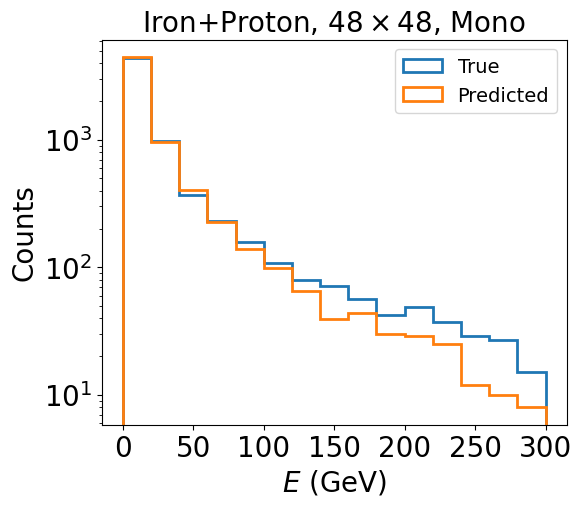

In [67]:
dbin=20
nbins = np.arange(0,300+dbin,dbin)

plt.figure(figsize=(6,5))
plt.hist(np.exp(test_e),bins=nbins,lw=2,histtype='step',label='True')
plt.hist(np.exp(ypred),bins=nbins,lw=2,histtype='step',label='Predicted')
plt.xlabel(r'$E$ (GeV)',size=20)
plt.ylabel(r'Counts',size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(loc='best')
plt.title(leg,size=20)
#plt.text(150,50,r"$\chi^2$/dof = %.3f"%(x2pdof),size=14)
plt.yscale('log')
#plt.savefig('../figures/'+fold+'e_vae_'+caso+'-2.pdf')
plt.show()

In [69]:
## Visualize Latent Space 
[z_mean, z_log_var, z, r_mean, r_log_var, r_vae, pz_mean] = encoder.predict([X_val[:ns],Y_val[:ns]],batch_size=batch_size)
tsne = MDS(n_components=2, random_state=0)
X_2d = tsne.fit_transform(z_mean)

fig = plt.figure(figsize=(6,5))
#ax = fig.add_subplot(111)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=test_e)
plt.title('TSNE visualization of latent space',size=16)
plt.grid(True)
cbar=plt.colorbar()
cbar.set_label(r'$log(E)$',labelpad=17, size=15,rotation=270,loc='center')
plt.xlim([-0.05,0.05])
plt.ylim([-0.05,0.05])
plt.xticks(size=16)
plt.yticks(size=16)
#plt.savefig('../figures/'+fold+'latent_space_'+caso+'.pdf')
plt.show()

NameError: name 'X_val' is not defined